In [1]:
import json
import smart_open
import pandas as pd
import os

# RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"
# MODEL_PATH = "olmo/1b/olmo-small-dolma-150B-mcli-results"
RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"
MODEL_PATH = "pythia/1b"

model_path = os.path.join(RESULTS_DIR, MODEL_PATH)

domains_with_subdomains = set()
for sheet_name in os.listdir(model_path):
    if sheet_name.endswith("subdomains.jsonl.gz") and not sheet_name.startswith("bits_per_byte"):
        domains_with_subdomains.add("_".join(sheet_name.split("_")[2:-1]))
    # print(sheet_name)

shared_cols = {
 'model',
 'model_size',
 'split',
 'tokens_seen',
 'training_dataset',
 'training_steps'
 }

non_domain_cols = {
    "date",
    "model",
    "model_kwargs",
    "full_model",
    "task",
    "processing_time",
    "num_instances",
    "tango_workspace",
    "tango_step",
    "model_max_length",
    "max_batch_tokens",
    "batch_size",
    "limit",
    "split",
    "random_subsample_seed",
    "model_size",
    "training_steps",
    "tokens_seen",
    "training_dataset"
}

def standardize_model_metadata(row):
    if row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-dolma-150B-mcli'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'model_kwargs' in row:
            assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
            del row['model_kwargs']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'Dolma V1.5'
    elif row['model'].startswith('EleutherAI/pythia-1b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 805736448 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    else:
        # pass
        raise ValueError(f"Unknown model: {row['model']}")
    return row

def read_jsonl(path):
    with smart_open.open(path, 'rt') as fin:
        for line in fin:
            data = standardize_model_metadata(json.loads(line))
            yield data

fringe_domains = {
    'ppl_manosphere_meta_sep',
    'ppl_4chan_meta_sep',
    'ppl_gab'
}

domains_without_subdomains = set(pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))['task']) - domains_with_subdomains
domains_without_subdomains_clean = set(d for d in domains_without_subdomains if all(fringe_domain not in d for fringe_domain in fringe_domains))

results_files_all = os.listdir(model_path)
results_files_clean = [f for f in results_files_all if all(fringe_domain not in f for fringe_domain in fringe_domains)]

In [2]:

ppl_redpajama_token_count_avg_logits = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_redpajama_token_count_avg_logits.jsonl.gz")))
ppl_redpajama_token_count_avg_logits.head()
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.jsonl.gz")))
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains
# ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
# ppl_metrics.head()

,model,subdomain,token,count,avg_logits,model_size,training_steps,tokens_seen,training_dataset
0,pythia,redpajama__books,analog,1,-18.806479,805736448,10000,20971520000,The Pile
1,pythia,redpajama__books,ou,1,-17.316435,805736448,10000,20971520000,The Pile
2,pythia,redpajama__books,Johnny,1,-16.327814,805736448,10000,20971520000,The Pile
3,pythia,redpajama__books,eclipse,1,-16.155434,805736448,10000,20971520000,The Pile
4,pythia,redpajama__books,bans,1,-16.144665,805736448,10000,20971520000,The Pile


In [3]:
from functools import reduce

def make_subdomain_of_task(model_path, task_names, metric_name):
    ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
    dfs = []
    assert set(task_names) <= set(ppl_metrics['task'])
    for task_name in task_names:
        task_df = ppl_metrics[ppl_metrics['task'] == task_name]
        new_df = task_df[list(shared_cols)].copy()
        new_df[task_name] = task_df[metric_name]
        dfs.append(new_df)
    
    return dfs

def get_metric_for_all_subdomains(model_path, sheet_names, metrics_name, include_non_subdomain_tasks=None):
    dfs = []
    if include_non_subdomain_tasks:
        dfs.extend(make_subdomain_of_task(model_path, include_non_subdomain_tasks, metrics_name))
    for k in sheet_names:
        if not k.endswith('subdomains.jsonl.gz'):
            continue
        if k.startswith(metrics_name):
            df = pd.DataFrame(read_jsonl(os.path.join(model_path, k)))
            
            df = df[list(df.columns.difference(non_domain_cols - shared_cols))]
            dfs.append(df)
    
    # join all the dfs on the domain cols, by concatenating the domain cols
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), dfs)
    return merged_df

def get_avg_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['avg_over_subdomains'] = df[domain_cols].mean(axis=1)
    return new_df

def get_median_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['median_over_subdomains'] = df[domain_cols].median(axis=1)
    return new_df

def get_win_rate_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['win_rate_over_subdomains'] = df.apply(lambda row: sum(row[domain_cols] == df[domain_cols].min()), axis=1) / len(domain_cols)
    return new_df

# def get_win_rate_over_all_subdomains_by_bin(df, bin_measure, bin_size):
#     domain_cols = list(set(df.columns) - shared_cols)
#     max_bin = df[bin_measure].max()
#     min_bin = df[bin_measure].min()
#     new_df = []
#     for i in range(min_bin, max_bin, bin_size):
#         bin_rows = df[(df[bin_measure] >= i) & (df[bin_measure] < i + bin_size)].copy()
#         if len(bin_rows) < 2:
#             print((i, i + bin_size))
#             continue
#         # check that bin has no repeats of the same model
#         assert len(bin_rows) == len(set(bin_rows['model']))
#         bin_rows[f'win_rate_in_bin'] = bin_rows.apply(lambda row: sum(row[domain_cols] == bin_rows[domain_cols].min()), axis=1) / len(domain_cols)
#         bin_rows[f'bin_{bin_measure}'] = (i, i + bin_size)
#         new_df.append(bin_rows)
#     new_df = pd.concat(new_df)
#     return new_df

def get_win_rate_over_all_subdomains_by_nearest(df, nearest_measure, max_distance):
    domain_cols = list(set(df.columns) - shared_cols)
    # sort df by nearest measure
    df = df.sort_values(by=[nearest_measure])
    # iterate over each row
    new_df = []
    row_buffer = []
    for i, row in df.iterrows():
        if len(row_buffer) == 0:
            row_buffer.append(row)
            continue
        elif row['model'] != row_buffer[0]['model']:
            row_buffer.append(row)
            continue
        else:
            row_df = pd.DataFrame(row_buffer)
            if (row_df[nearest_measure].max() - row_df[nearest_measure].min() > max_distance):
                print(row_df[list(shared_cols)])
            if len(row_buffer) >1 and (row_df[nearest_measure].max() - row_df[nearest_measure].min() <= max_distance):
                assert len(row_df) == len(set(row_df['model']))
                row_df[f'win_rate_with_nearest'] = row_df.apply(lambda row: sum(row[domain_cols] == row_df[domain_cols].min()), axis=1) / len(domain_cols)
                new_df.append(row_df)
            row_buffer = []
            row_buffer.append(row)
    
    new_df = pd.concat(new_df)
    return new_df
            



    

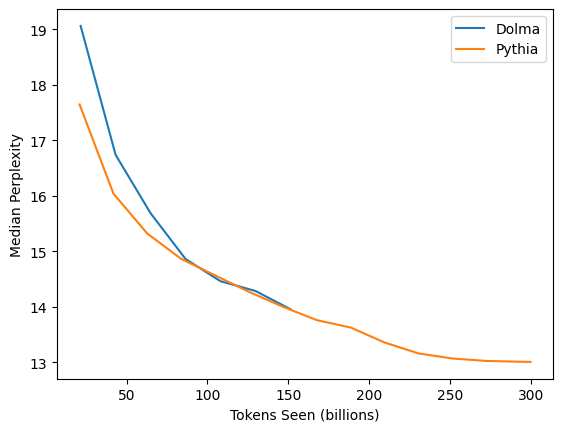

In [4]:
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_ppl_token_all_domains_median = get_median_over_all_subdomains(get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean))

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_ppl_token_all_domains_median = get_median_over_all_subdomains(get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean))

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = dolma_ppl_token_all_domains_median['tokens_seen'] / 1000000000
dolma_y_axis = dolma_ppl_token_all_domains_median['median_over_subdomains']

pythia_x_axis = pythia_ppl_token_all_domains_median['tokens_seen'] / 1000000000
pythia_y_axis = pythia_ppl_token_all_domains_median['median_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Median Perplexity")
plt.legend()
plt.show()

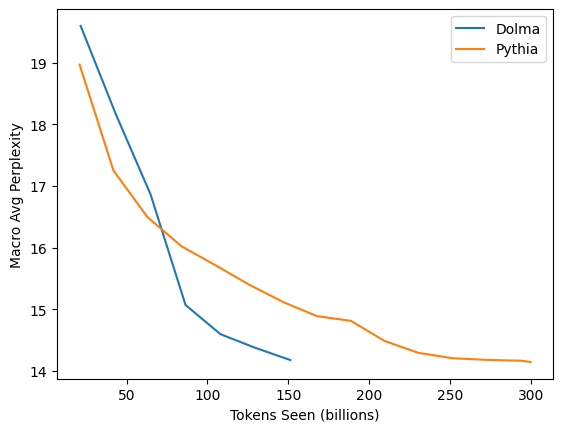

In [5]:
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_ppl_token_all_domains_avg = get_avg_over_all_subdomains(get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean))

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_ppl_token_all_domains_avg = get_avg_over_all_subdomains(get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean))

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = dolma_ppl_token_all_domains_avg['tokens_seen'] / 1000000000
dolma_y_axis = dolma_ppl_token_all_domains_avg['avg_over_subdomains']

pythia_x_axis = pythia_ppl_token_all_domains_avg['tokens_seen'] / 1000000000
pythia_y_axis = pythia_ppl_token_all_domains_avg['avg_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Macro Avg Perplexity")
plt.legend()
plt.show()

<BarContainer object of 2 artists>

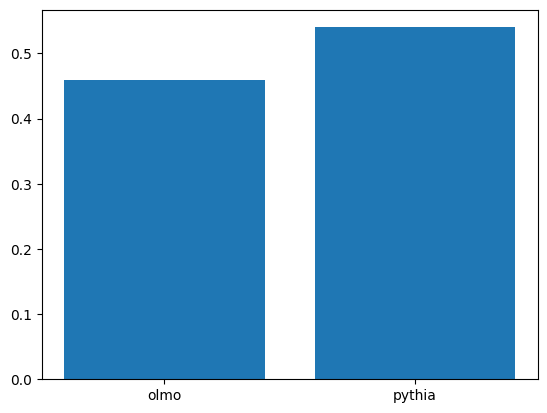

In [6]:
# bar chart of win rate over all final models
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])

# get the max 'tokens_seen' for each model
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby('model').last().reset_index()
win_rate = get_win_rate_over_all_subdomains(all_subdomains)

# make a bar chart of the win rate
win_rate = win_rate.sort_values(by=['win_rate_over_subdomains'])
plt.bar(win_rate['model'], win_rate['win_rate_over_subdomains'])

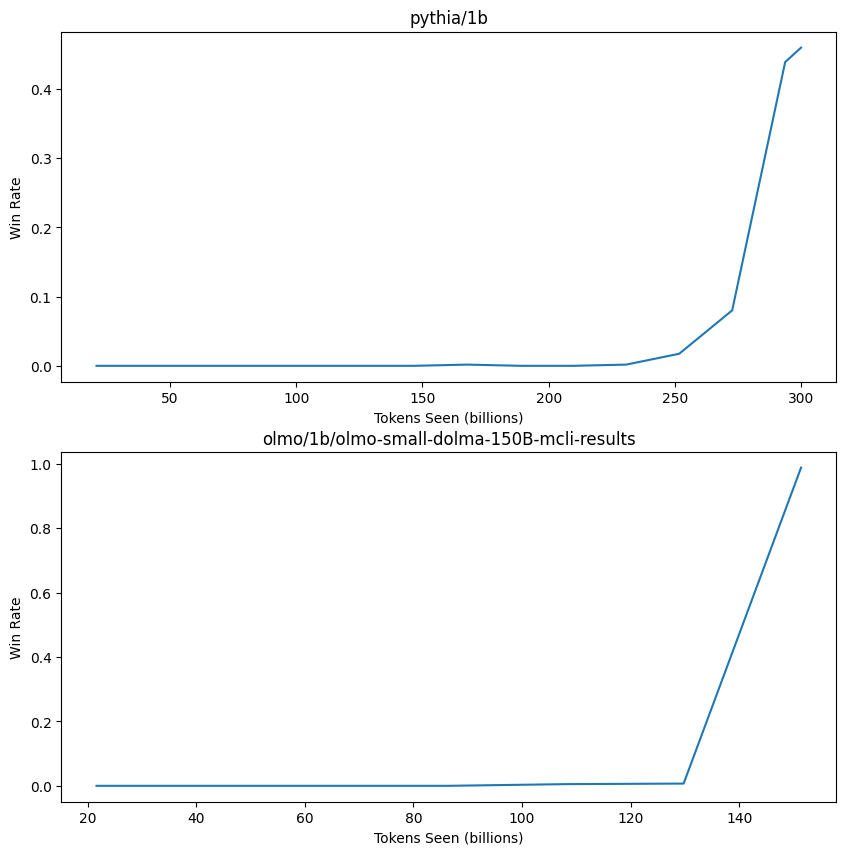

In [7]:
# win rate over training progress for each model seperately
models = [
    "pythia/1b",
    "olmo/1b/olmo-small-dolma-150B-mcli-results"
]

import matplotlib.pyplot as plt
import numpy as np

# one subplot for each model
fig, axs = plt.subplots(len(models), figsize=(10, 10))

# line chare for each model
for i, model in enumerate(models):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
    win_rate = get_win_rate_over_all_subdomains(all_subdomains)
    x_axis = win_rate['tokens_seen'] / 1000000000
    y_axis = win_rate['win_rate_over_subdomains']
    axs[i].plot(x_axis, y_axis)
    axs[i].set_title(model)
    axs[i].set_xlabel("Tokens Seen (billions)")
    axs[i].set_ylabel("Win Rate")

plt.show()



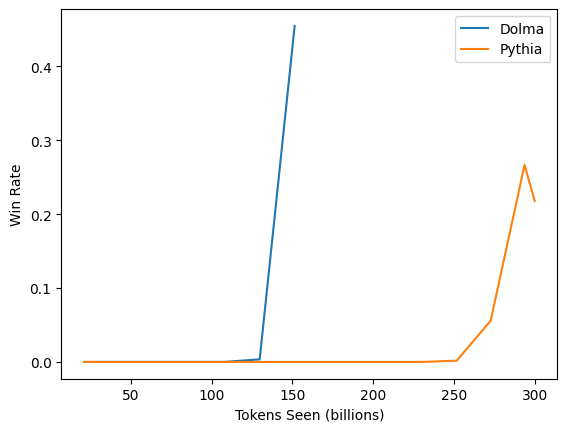

In [8]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains(all_subdomains)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['tokens_seen'] / 1000000000
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_over_subdomains']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['tokens_seen'] / 1000000000
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Win Rate")
plt.legend()
plt.show()



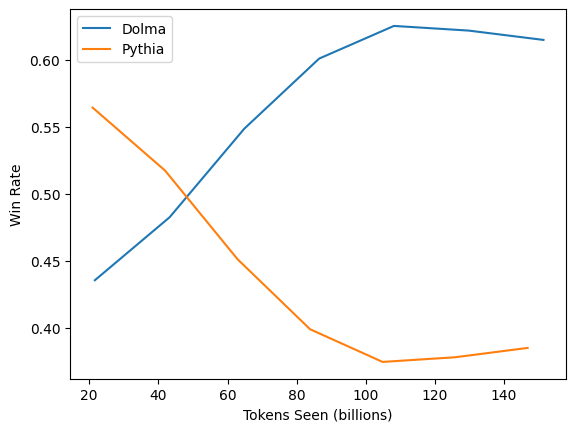

In [9]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains_by_nearest(all_subdomains, 'tokens_seen', 10000000000)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['tokens_seen'] / 1000000000
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_with_nearest']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['tokens_seen'] / 1000000000
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_with_nearest']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

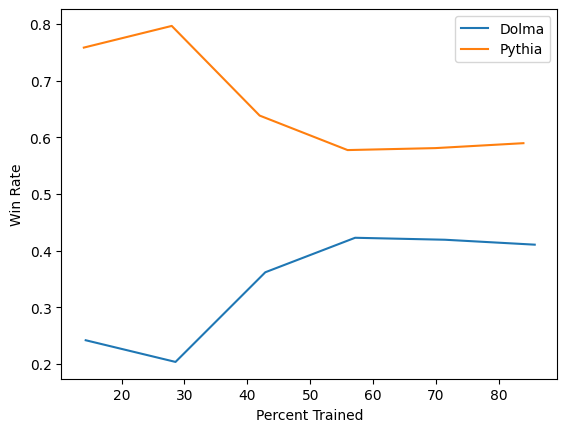

In [10]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
pythia_all_subdomains['percent_trained'] = pythia_all_subdomains['training_steps'] / pythia_all_subdomains['training_steps'].max()

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
dolma_all_subdomains['percent_trained'] = dolma_all_subdomains['training_steps'] / dolma_all_subdomains['training_steps'].max()

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains_by_nearest(all_subdomains, 'percent_trained', .2)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['percent_trained'] * 100
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_with_nearest']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['percent_trained'] * 100
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_with_nearest']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Percent Trained")
plt.ylabel("Win Rate")
plt.legend()
plt.show()